In [1]:
import matplotlib.pyplot as plt
import lightgbm as lgb
import xgboost as xgb
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import joblib
import sys

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings('ignore')

from src import (
    DataPreprocessor,
    train_linear_models,
    train_random_forest,
    train_boosting_models,
    train_mlp,
    ModelComparator,
    FeatureImportanceAnalyzer,
    load_all_data,
    prepare_features_target,
    save_all_results,
    print_data_summary
)

2025-11-28 19:41:12.007747: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-28 19:41:12.150230: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-28 19:41:16.660636: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


In [2]:
# Load all data TESTING FOURIER DATASET
metrics_df = pd.read_csv('Data/VED_DynamicData_Fourier.csv')
static_ice_hev = pd.read_csv('Data/VED_Static_Data_ICE&HEV.csv')
static_phev_ev = pd.read_csv('Data/VED_Static_Data_PHEV&EV.csv')

print(f"Metrics CSV: {metrics_df.shape}")
print(f"Static ICE/HEV: {static_ice_hev.shape}")
print(f"Static PHEV/EV: {static_phev_ev.shape}")

# Check columns in metrics_df
print(f"\nMetrics CSV columns (first 10): {metrics_df.columns.tolist()[:10]}")
print(f"Static data columns: {static_ice_hev.columns.tolist()}")

# Combine static data
static_data = pd.concat([static_ice_hev, static_phev_ev], ignore_index=True)
print(f"Combined static data: {static_data.shape}")

if 'filename' in metrics_df.columns and 'VehId' in static_data.columns:
    print("\nMetrics has 'filename' but not 'VehId'. Need to match vehicles differently.")
    print("For now, using all rows from metrics (54 vehicle-weeks)")
    data = metrics_df.copy()
    print(f"Using metrics data: {data.shape[0]} samples, {data.shape[1]} features")
else:
    # Try standard merge on VehId
    data = metrics_df.merge(static_data, on='VehId', how='inner')
    print(f"Merged data: {data.shape[0]} samples, {data.shape[1]} features")

print(f"\nData shape: {data.shape}")
print(f"Data columns (first 15): {data.columns.tolist()[:15]}")


Metrics CSV: (54, 354)
Static ICE/HEV: (357, 7)
Static PHEV/EV: (27, 7)

Metrics CSV columns (first 10): ['filename', 'VehId', 'Vehicle Speed[km/h]_fft_magnitude_0', 'Vehicle Speed[km/h]_fft_frequency_0', 'Vehicle Speed[km/h]_fft_magnitude_1', 'Vehicle Speed[km/h]_fft_frequency_1', 'Vehicle Speed[km/h]_fft_magnitude_2', 'Vehicle Speed[km/h]_fft_frequency_2', 'Vehicle Speed[km/h]_fft_magnitude_3', 'Vehicle Speed[km/h]_fft_frequency_3']
Static data columns: ['VehId', 'Vehicle Type', 'Vehicle Class', 'Engine Configuration & Displacement', 'Transmission', 'Drive Wheels', 'Generalized_Weight']
Combined static data: (384, 8)

Metrics has 'filename' but not 'VehId'. Need to match vehicles differently.
For now, using all rows from metrics (54 vehicle-weeks)
Using metrics data: 54 samples, 354 features

Data shape: (54, 354)
Data columns (first 15): ['filename', 'VehId', 'Vehicle Speed[km/h]_fft_magnitude_0', 'Vehicle Speed[km/h]_fft_frequency_0', 'Vehicle Speed[km/h]_fft_magnitude_1', 'Vehicle

In [3]:
# Define exclusion columns (exclude from features, but keep VehId for identification)
exclude_cols = ['filename', 'Trip', 'Timestamp', 'Timestamp(ms)', 
                'DayNum_mean', 'DayNum_median', 'DayNum_std', 'DayNum_min', 'DayNum_max',
                'DayNum_q25', 'DayNum_q75', 'DayNum_sum', 'DayNum_count', 'DayNum_mode',
                'DayNum_mode_count', 'DayNum_range', 'DayNum_iqr', 'DayNum_cv']

# Keep VehId for identification
veh_ids = data['VehId'].values if 'VehId' in data.columns else None

# Get numeric feature columns (excluding non-numeric and identifiers)
feature_cols = [col for col in data.columns 
               if col not in exclude_cols 
               and col != 'VehId'  # Explicitly exclude VehId from features
               and data[col].dtype in [np.float64, np.int64]]

print(f"Total features selected: {len(feature_cols)}")
print(f"First 10 features: {feature_cols[:10]}")
print(f"VehId preserved for vehicle identification: {veh_ids is not None}")

# Prepare X and y
X = data[feature_cols].fillna(data[feature_cols].mean())

# Find a suitable target column (numeric, not an identifier)
# Try to find engine-related features or use the first available numeric column
possible_targets = [col for col in feature_cols if 'EngDisp' in col or 'Engine' in col]
if possible_targets:
    target_col = possible_targets[0]
else:
    # Use first meaningful feature as target
    target_col = feature_cols[0]

y = data[target_col].fillna(data[target_col].mean()).values

print(f"\nFeature matrix shape: {X.shape}")
print(f"Target variable: {target_col}")
print(f"Target shape: {y.shape}")
print(f"Target - Mean: {y.mean():.4f}, Std: {y.std():.4f}, Min: {y.min():.4f}, Max: {y.max():.4f}")


Total features selected: 352
First 10 features: ['Vehicle Speed[km/h]_fft_magnitude_0', 'Vehicle Speed[km/h]_fft_frequency_0', 'Vehicle Speed[km/h]_fft_magnitude_1', 'Vehicle Speed[km/h]_fft_frequency_1', 'Vehicle Speed[km/h]_fft_magnitude_2', 'Vehicle Speed[km/h]_fft_frequency_2', 'Vehicle Speed[km/h]_fft_magnitude_3', 'Vehicle Speed[km/h]_fft_frequency_3', 'Vehicle Speed[km/h]_fft_magnitude_4', 'Vehicle Speed[km/h]_fft_frequency_4']
VehId preserved for vehicle identification: True

Feature matrix shape: (54, 352)
Target variable: Engine RPM[RPM]_fft_magnitude_0
Target shape: (54,)
Target - Mean: 31029457.5142, Std: 7763086.1772, Min: 13345948.0617, Max: 51288314.2675


In [4]:
# Split: 80% dev (for train+val), 20% test
# Then dev split: 80% train, 20% val from dev

# Create indices for splitting while preserving VehId
indices = np.arange(len(X))

# First split: dev (80%) vs test (20%)
idx_dev, idx_test, X_dev, X_test, y_dev, y_test = train_test_split(
    indices, X, y, test_size=0.2, random_state=69
)

# Get VehIds for each split if available
if veh_ids is not None:
    veh_ids_dev = veh_ids[idx_dev]
    veh_ids_test = veh_ids[idx_test]
else:
    veh_ids_dev = None
    veh_ids_test = None

print(f"Dev set: {X_dev.shape[0]} samples ({len(X_dev)/len(X)*100:.1f}%)")
print(f"Test set: {X_test.shape[0]} samples ({len(X_test)/len(X)*100:.1f}%)")

# Second split: dev into train (80% of dev ≈ 64% of total) vs val (20% of dev ≈ 16% of total)
X_train, X_val, y_train, y_val = train_test_split(
    X_dev, y_dev, test_size=0.2, random_state=69
)

if veh_ids_dev is not None:
    veh_ids_train = veh_ids_dev[:len(X_train)]
    veh_ids_val = veh_ids_dev[len(X_train):]
else:
    veh_ids_train = None
    veh_ids_val = None

print(f"Train set: {X_train.shape[0]} samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"Val set: {X_val.shape[0]} samples ({len(X_val)/len(X)*100:.1f}%)")
print(f"Test set: {X_test.shape[0]} samples ({len(X_test)/len(X)*100:.1f}%)")

# Verify split
total = len(X_train) + len(X_val) + len(X_test)
print(f"\nTotal samples: {total}")
print(f"Train: {len(X_train)/total*100:.1f}% | Val: {len(X_val)/total*100:.1f}% | Test: {len(X_test)/total*100:.1f}%")

# Store VehId information for later use
print(f"\nVehId information preserved:")
if veh_ids_train is not None:
    print(f"Train VehIds: {len(veh_ids_train)} cars")
    print(f"Val VehIds: {len(veh_ids_val)} cars")
    print(f"Test VehIds: {len(veh_ids_test)} cars")


Dev set: 43 samples (79.6%)
Test set: 11 samples (20.4%)
Train set: 34 samples (63.0%)
Val set: 9 samples (16.7%)
Test set: 11 samples (20.4%)

Total samples: 54
Train: 63.0% | Val: 16.7% | Test: 20.4%

VehId information preserved:
Train VehIds: 34 cars
Val VehIds: 9 cars
Test VehIds: 11 cars


In [5]:
# Create scaler and fit on training data ONLY
scaler = StandardScaler()
scaler.fit(X_train)

# Scale all sets
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Convert to DataFrames for easier handling (optional)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_cols, index=X_train.index)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=feature_cols, index=X_val.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_cols, index=X_test.index)
 
# Sanitize feature names for XGBoost (remove special characters)
sanitized_feature_cols = [col.replace('[', '').replace(']', '').replace('<', '').replace('>', '') for col in feature_cols]
X_train_scaled.columns = sanitized_feature_cols
X_val_scaled.columns = sanitized_feature_cols
X_test_scaled.columns = sanitized_feature_cols

print(f"Train set shape: {X_train_scaled.shape}")
print(f"Val set shape: {X_val_scaled.shape}")
print(f"Test set shape: {X_test_scaled.shape}")
print(f"\nFeature statistics after scaling (train):")
print(f"Mean: {X_train_scaled.mean().mean():.6f}")
print(f"Std: {X_train_scaled.std().mean():.6f}")


Train set shape: (34, 352)
Val set shape: (9, 352)
Test set shape: (11, 352)

Feature statistics after scaling (train):
Mean: 0.000000
Std: 1.015038


In [6]:
def calculate_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100 if np.all(y_true != 0) else np.nan
    return {'RMSE': rmse, 'MAE': mae, 'R2': r2, 'MAPE': mape}

all_models = {}
all_predictions = {}

# -------- Linear OLS --------
print("\n→ Training Linear OLS...")
model_ols = LinearRegression()
model_ols.fit(X_train_scaled, y_train)
preds_ols = model_ols.predict(X_test_scaled)

all_models['Linear OLS'] = model_ols
all_predictions['Linear OLS'] = preds_ols
metrics = calculate_metrics(y_test, preds_ols)
print(f"Trained - RMSE: {metrics['RMSE']:.4f}, R²: {metrics['R2']:.4f}")

# -------- Linear Ridge --------
print("\n→ Training Linear Ridge...")
model_ridge = Ridge(alpha=1.0, random_state=42)
model_ridge.fit(X_train_scaled, y_train)
preds_ridge = model_ridge.predict(X_test_scaled)

all_models['Linear Ridge'] = model_ridge
all_predictions['Linear Ridge'] = preds_ridge
metrics = calculate_metrics(y_test, preds_ridge)
print(f"Trained - RMSE: {metrics['RMSE']:.4f}, R²: {metrics['R2']:.4f}")

# -------- Linear Lasso --------
print("\n→ Training Linear Lasso...")
model_lasso = Lasso(alpha=0.01, random_state=42, max_iter=10000)
model_lasso.fit(X_train_scaled, y_train)
preds_lasso = model_lasso.predict(X_test_scaled)

all_models['Linear Lasso'] = model_lasso
all_predictions['Linear Lasso'] = preds_lasso
metrics = calculate_metrics(y_test, preds_lasso)
print(f"Trained - RMSE: {metrics['RMSE']:.4f}, R²: {metrics['R2']:.4f}")


# -------- Random Forest --------
print("\n→ Training Random Forest...")
model_rf = RandomForestRegressor(n_estimators=200, max_depth=20, min_samples_split=5, random_state=42, n_jobs=-1)
model_rf.fit(X_train_scaled, y_train)
preds_rf = model_rf.predict(X_test_scaled)

all_models['Random Forest'] = model_rf
all_predictions['Random Forest'] = preds_rf
metrics = calculate_metrics(y_test, preds_rf)
print(f"Trained - RMSE: {metrics['RMSE']:.4f}, R²: {metrics['R2']:.4f}")

# -------- XGBoost --------
print("\n→ Training XGBoost...")
model_xgb = xgb.XGBRegressor(
    n_estimators=300, learning_rate=0.05, max_depth=7, 
    random_state=42, verbosity=0
)
model_xgb.fit(X_train_scaled, y_train, eval_set=[(X_val_scaled, y_val)], verbose=False)
preds_xgb = model_xgb.predict(X_test_scaled)

all_models['XGBoost'] = model_xgb
all_predictions['XGBoost'] = preds_xgb
metrics = calculate_metrics(y_test, preds_xgb)
print(f"Trained - RMSE: {metrics['RMSE']:.4f}, R²: {metrics['R2']:.4f}")

# -------- LightGBM --------
print("\n→ Training LightGBM...")
model_lgbm = lgb.LGBMRegressor(
    n_estimators=300, learning_rate=0.05, max_depth=7,
    random_state=42, verbose=-1
)
model_lgbm.fit(X_train_scaled, y_train)
preds_lgbm = model_lgbm.predict(X_test_scaled)

all_models['LightGBM'] = model_lgbm
all_predictions['LightGBM'] = preds_lgbm
metrics = calculate_metrics(y_test, preds_lgbm)
print(f"Trained - RMSE: {metrics['RMSE']:.4f}, R²: {metrics['R2']:.4f}")

print(f"Models: {list(all_models.keys())}")



→ Training Linear OLS...
Trained - RMSE: 663800291.5244, R²: -5214.7089

→ Training Linear Ridge...
Trained - RMSE: 657400440.0335, R²: -5114.6221

→ Training Linear Lasso...
Trained - RMSE: 2570284812.3151, R²: -78197.9587

→ Training Random Forest...
Trained - RMSE: 4629021.4176, R²: 0.7464

→ Training XGBoost...
Trained - RMSE: 2147577.7726, R²: 0.9454

→ Training LightGBM...
Trained - RMSE: 9407245.9656, R²: -0.0475
Models: ['Linear OLS', 'Linear Ridge', 'Linear Lasso', 'Random Forest', 'XGBoost', 'LightGBM']


In [7]:
comparator = ModelComparator()

for model_name, predictions in all_predictions.items():
    comparator.add_model_results(model_name, y_test, predictions)

comparator.print_summary()

comparison_df = comparator.get_comparison_dataframe()
print("\nDetailed Comparison Table:")
print(comparison_df.round(6).to_string())

comparison_df.to_csv('results/model_comparison.csv')

if veh_ids_test is not None:
    detailed_results = pd.DataFrame({
        'VehId': veh_ids_test,
        'Actual': y_test
    })
    
    for model_name, predictions in all_predictions.items():
        detailed_results[f'{model_name}_Pred'] = predictions
    
    detailed_results.to_csv('results/model_predictions_with_vehicles.csv', index=False)
    print(f"Detailed predictions with vehicle IDs saved to results/model_predictions_with_vehicles.csv")
    print(f"Samples: {len(detailed_results)} test vehicles")



MODEL COMPARISON SUMMARY
                       RMSE           MAE            R2         MAPE           MSE  Training Time
Linear OLS     6.638003e+08  2.046440e+08  -5214.708936   987.187615  4.406308e+17            0.0
Linear Ridge   6.574004e+08  2.027171e+08  -5114.622051   977.802378  4.321753e+17            0.0
Linear Lasso   2.570285e+09  7.792390e+08 -78197.958672  3785.271758  6.606364e+18            0.0
Random Forest  4.629021e+06  2.830449e+06      0.746361     7.349727  2.142784e+13            0.0
XGBoost        2.147578e+06  1.698530e+06      0.945407     4.751836  4.612090e+12            0.0
LightGBM       9.407246e+06  7.334279e+06     -0.047523    21.903798  8.849628e+13            0.0

BEST MODELS:
  RMSE:  XGBoost (2147577.772614)
  MAE:   XGBoost (1698530.338986)
  R²:    XGBoost (0.945407)
  MAPE:  XGBoost (4.75%)


Detailed Comparison Table:
                       RMSE           MAE            R2         MAPE           MSE  Training Time
Linear OLS     6.638003e+0

In [8]:
project_path = '/media/vanafa/1TB/Workspace/Cuatri 6/ML/TP Final'
if project_path not in sys.path:
    sys.path.insert(0, project_path)

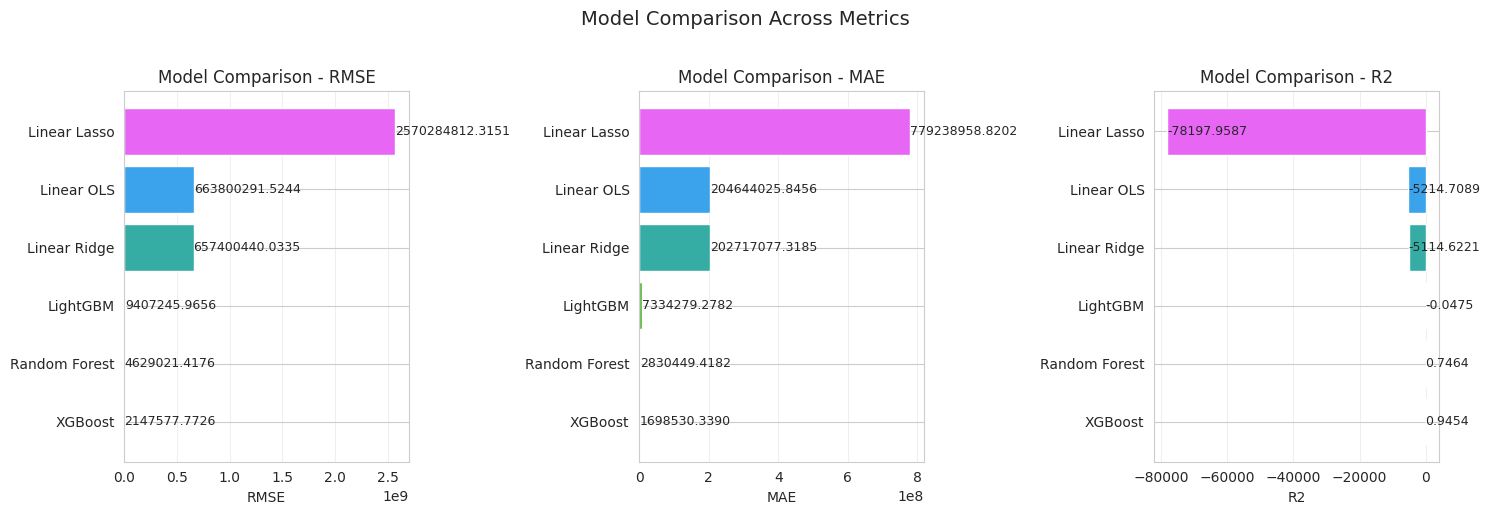


Best model: XGBoost (RMSE: 2147577.772614)


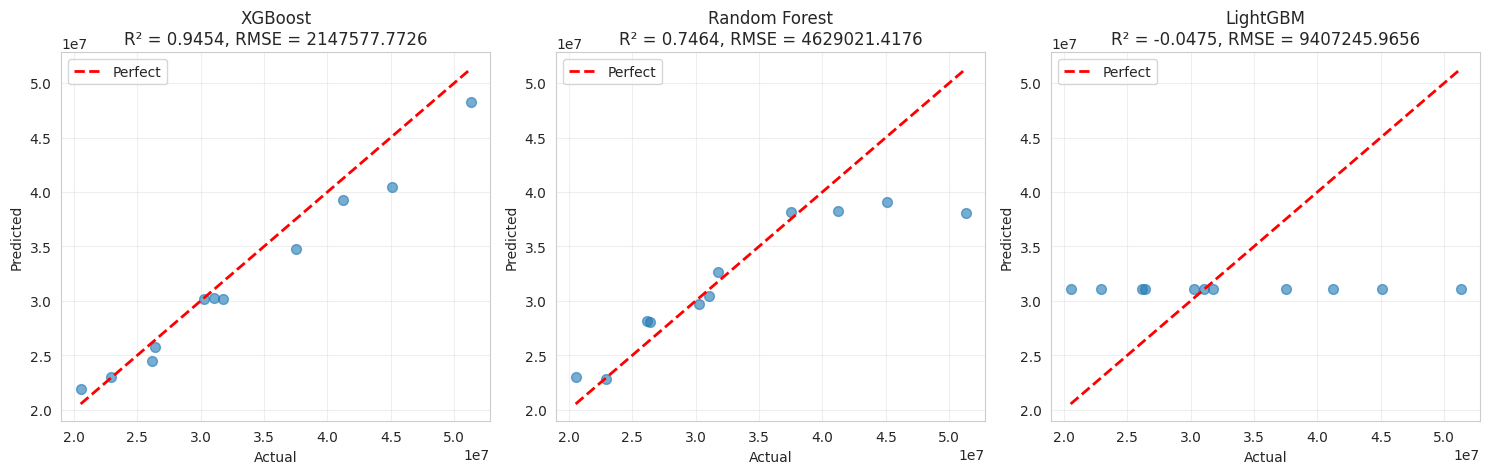

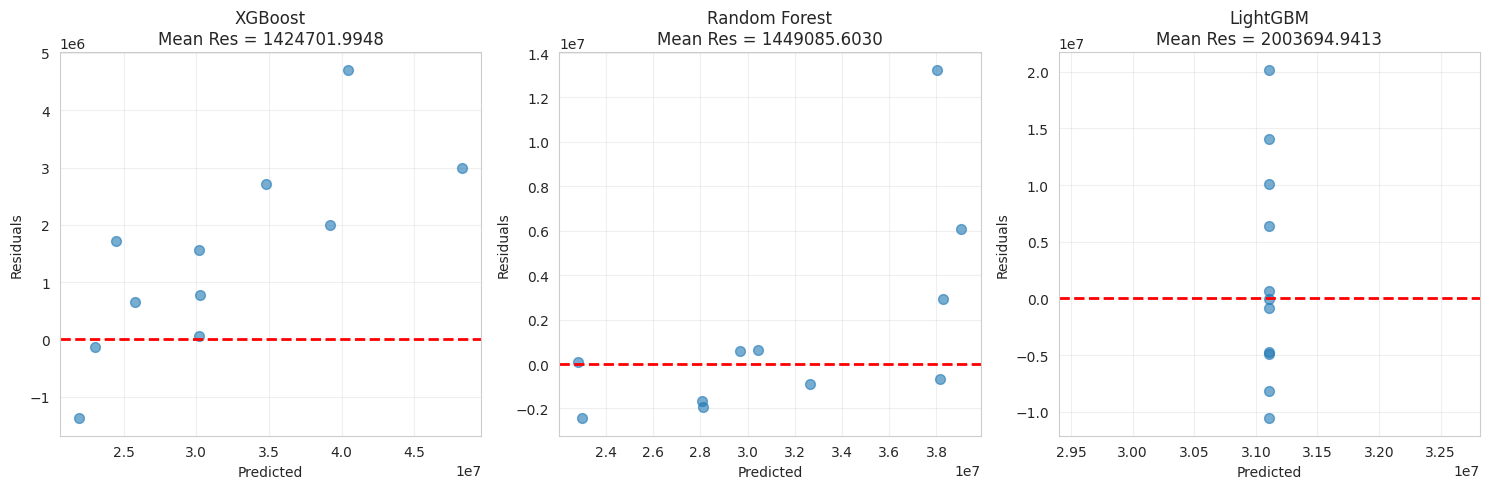

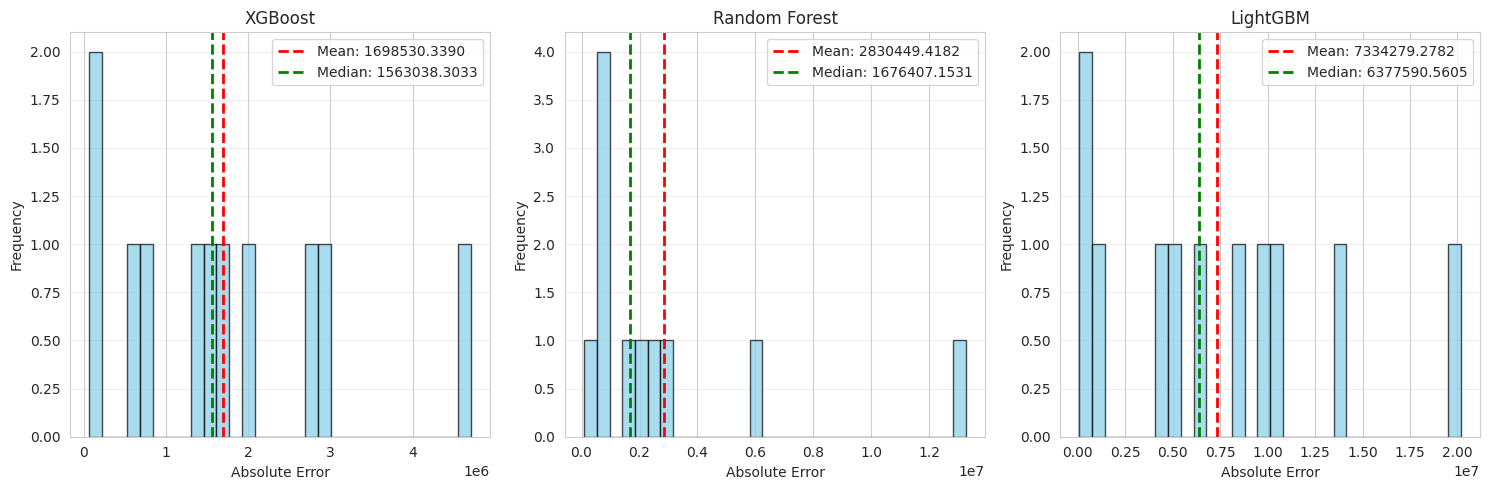

In [9]:
# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 5)

# 1. Model Comparison - RMSE
fig = comparator.plot_comparison(metrics=['RMSE', 'MAE', 'R2'], figsize=(15, 5))
plt.suptitle('Model Comparison Across Metrics', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig('results/model_comparison_metrics.png', dpi=100, bbox_inches='tight')
plt.show()

# 2. Predictions vs Actual for top 3 models
best_model_name, best_rmse = comparator.get_best_model('RMSE')
print(f"\nBest model: {best_model_name} (RMSE: {best_rmse:.6f})")

# Get top 3 models by RMSE
top_3_models = comparison_df['RMSE'].nsmallest(3).index.tolist()
top_3_preds = {name: all_predictions[name] for name in top_3_models}

fig = plt.figure(figsize=(15, 5))
for idx, (model_name, preds) in enumerate(top_3_preds.items(), 1):
    ax = plt.subplot(1, 3, idx)
    
    r2 = comparison_df.loc[model_name, 'R2']
    rmse = comparison_df.loc[model_name, 'RMSE']
    
    ax.scatter(y_test, preds, alpha=0.6, s=50)
    
    # Perfect prediction line
    min_val = min(y_test.min(), preds.min())
    max_val = max(y_test.max(), preds.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect')
    
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    ax.set_title(f'{model_name}\nR² = {r2:.4f}, RMSE = {rmse:.4f}')
    ax.grid(True, alpha=0.3)
    ax.legend()

plt.tight_layout()
plt.savefig('results/predictions_vs_actual_top3.png', dpi=100, bbox_inches='tight')
plt.show()

# 3. Residuals plot for top 3 models
fig = plt.figure(figsize=(15, 5))
for idx, (model_name, preds) in enumerate(top_3_preds.items(), 1):
    ax = plt.subplot(1, 3, idx)
    
    residuals = y_test - preds
    
    ax.scatter(preds, residuals, alpha=0.6, s=50)
    ax.axhline(y=0, color='r', linestyle='--', lw=2)
    
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Residuals')
    ax.set_title(f'{model_name}\nMean Res = {residuals.mean():.4f}')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('results/residuals_top3.png', dpi=100, bbox_inches='tight')
plt.show()

# 4. Error distribution for top 3 models
fig = plt.figure(figsize=(15, 5))
for idx, (model_name, preds) in enumerate(top_3_preds.items(), 1):
    ax = plt.subplot(1, 3, idx)
    
    errors = np.abs(y_test - preds)
    
    ax.hist(errors, bins=30, edgecolor='black', alpha=0.7, color='skyblue')
    ax.axvline(errors.mean(), color='r', linestyle='--', lw=2, label=f'Mean: {errors.mean():.4f}')
    ax.axvline(np.median(errors), color='g', linestyle='--', lw=2, label=f'Median: {np.median(errors):.4f}')
    
    ax.set_xlabel('Absolute Error')
    ax.set_ylabel('Frequency')
    ax.set_title(f'{model_name}')
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('results/error_distribution_top3.png', dpi=100, bbox_inches='tight')
plt.show()

In [10]:
analyzer = FeatureImportanceAnalyzer(feature_cols)

if hasattr(all_models['Random Forest'], 'get_feature_importance'):
    importance = all_models['Random Forest'].get_feature_importance()
    analyzer.add_importance('Random Forest', importance, 'importance')

if hasattr(all_models['XGBoost'], 'get_feature_importance'):
    importance = all_models['XGBoost'].get_feature_importance()
    analyzer.add_importance('XGBoost', importance, 'importance')

if hasattr(all_models['LightGBM'], 'get_feature_importance'):
    importance = all_models['LightGBM'].get_feature_importance()
    analyzer.add_importance('LightGBM', importance, 'importance')

if hasattr(all_models['Linear OLS'], 'coef_'):
    analyzer.add_importance('Linear OLS', np.abs(all_models['Linear OLS'].coef_), 'coefficient')

analyzer.print_summary(n=15)

for model_name in ['Random Forest', 'XGBoost', 'LightGBM']:
    if model_name in analyzer.importances:
        fig = analyzer.plot_feature_importance(model_name, n=15, figsize=(10, 8))
        plt.tight_layout()
        plt.savefig(f'results/feature_importance_{model_name.lower().replace(" ", "_")}.png', 
                    dpi=100, bbox_inches='tight')
        plt.show()


FEATURE IMPORTANCE ANALYSIS


Linear OLS - Top 15 Features:
------------------------------------------------------------
   1. Engine RPM[RPM]_fft_magnitude_0          685011.176618
   2. Engine RPM[RPM]_fft_magnitude_1          560648.215331
   3. Air Conditioning Power[Watts]_fft_frequency_0 488890.786950
   4. Long Term Fuel Trim Bank 1[%]_fft_frequency_2 397256.027129
   5. Short Term Fuel Trim Bank 2[%]_fft_frequency_9 352623.444772
   6. Long Term Fuel Trim Bank 2[%]_fft_frequency_0 310202.082349
   7. Short Term Fuel Trim Bank 1[%]_fft_frequency_5 302885.186120
   8. MAF[g/sec]_fft_magnitude_1               301418.856582
   9. HV Battery SOC[%]_fft_frequency_2        287574.369566
  10. Vehicle Speed[km/h]_fft_frequency_4      275588.902942
  11. Long Term Fuel Trim Bank 2[%]_fft_frequency_4 274055.550003
  12. Long Term Fuel Trim Bank 2[%]_fft_frequency_7 272514.590338
  13. HV Battery Voltage[V]_fft_magnitude_0    269914.013182
  14. HV Battery Current[A]_fft_energy         2

In [11]:
best_model_name, best_rmse = comparator.get_best_model('RMSE')
best_mae = comparator.get_best_model('MAE')[1]
best_r2 = comparator.get_best_model('R2')[1]

print(f"\nBEST MODEL: {best_model_name}")
print(f"RMSE: {best_rmse:.6f}")
print(f"MAE:  {best_mae:.6f}")
print(f"R²:   {best_r2:.6f}")

print("\nMODEL RANKING (by RMSE):")
ranking = comparison_df.sort_values('RMSE')
for i, (model, row) in enumerate(ranking.iterrows(), 1):
    print(f"{i}. {model:20s} | RMSE: {row['RMSE']:10.6f} | MAE: {row['MAE']:10.6f} | R²: {row['R2']:8.6f}")

print("METRICS INTERPRETATION")
print("""
RMSE (Root Mean Squared Error):
  - Average magnitude of prediction errors
  - Lower is better
  - Same units as target variable

MAE (Mean Absolute Error):
  - Average absolute prediction error
  - More interpretable than RMSE
  - Lower is better

R² (Coefficient of Determination):
  - Proportion of variance explained by model
  - 1.0 = perfect, 0.0 = no better than mean
  - Higher is better

MAPE (Mean Absolute Percentage Error):
  - Percentage error relative to actual values
  - Useful for comparing across scales
  - Lower is better (%)
""")

best_model = all_models[best_model_name]
if hasattr(best_model, 'save_model'):
    best_model.save_model(f'models/saved_models/best_model_{best_model_name.replace(" ", "_")}.pkl')

for model_name, model in all_models.items():
    if hasattr(model, 'save_model'):
        ext = '.h5' if 'MLP' in model_name else '.pkl'
        model.save_model(f'models/saved_models/{model_name.replace(" ", "_")}{ext}')

joblib.dump(scaler, 'models/saved_models/feature_scaler.pkl')

print(f"""
Results saved to:
  - results/model_comparison.csv (metrics table)
  - results/model_comparison_metrics.png (comparison plot)
  - results/predictions_vs_actual_top3.png (predictions plot)
  - results/residuals_top3.png (residuals plot)
  - results/error_distribution_top3.png (error distribution)
  - results/feature_importance_*.png (feature importance plots)

Models saved to:
  - models/saved_models/best_model_*.pkl
  - models/saved_models/*_model.pkl/.h5
  - models/saved_models/feature_scaler.pkl
""")


BEST MODEL: XGBoost
RMSE: 2147577.772614
MAE:  1698530.338986
R²:   0.945407

MODEL RANKING (by RMSE):
1. XGBoost              | RMSE: 2147577.772614 | MAE: 1698530.338986 | R²: 0.945407
2. Random Forest        | RMSE: 4629021.417550 | MAE: 2830449.418204 | R²: 0.746361
3. LightGBM             | RMSE: 9407245.965617 | MAE: 7334279.278186 | R²: -0.047523
4. Linear Ridge         | RMSE: 657400440.033467 | MAE: 202717077.318497 | R²: -5114.622051
5. Linear OLS           | RMSE: 663800291.524420 | MAE: 204644025.845553 | R²: -5214.708936
6. Linear Lasso         | RMSE: 2570284812.315065 | MAE: 779238958.820232 | R²: -78197.958672
METRICS INTERPRETATION

RMSE (Root Mean Squared Error):
  - Average magnitude of prediction errors
  - Lower is better
  - Same units as target variable

MAE (Mean Absolute Error):
  - Average absolute prediction error
  - More interpretable than RMSE
  - Lower is better

R² (Coefficient of Determination):
  - Proportion of variance explained by model
  - 1.0 = p